In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_coherence import coherence_at_resp_job
from bibliotheque import get_pos, init_nan_da, df_baseline
import mne
import os
from configuration import base_folder

In [2]:
concat = []
for run_key in run_keys:
    concat.append(coherence_at_resp_job.get(run_key).to_dataframe())
coherence = pd.concat(concat)

coherence_at_resp is processing ('P19_baseline',)
coherence is processing ('P19_baseline',)
coherence_at_resp is processing ('P19_music',)
coherence is processing ('P19_music',)
coherence_at_resp is processing ('P19_odor',)
coherence is processing ('P19_odor',)
coherence_at_resp is processing ('P20_baseline',)
coherence is processing ('P20_baseline',)
coherence_at_resp is processing ('P20_music',)
coherence is processing ('P20_music',)
coherence_at_resp is processing ('P20_odor',)
coherence is processing ('P20_odor',)


In [3]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_coherence','log_max_coherence']

In [4]:
coherence = coherence.set_index(indexes).astype(float).reset_index()
coherence['log_max_coherence'] = np.log(coherence['max_coherence'])

In [5]:
coherence

participant   session chan  fmax_resp     max_resp  max_coherence  \
0            P01  baseline  Fp1   0.356259   882.435901       0.027298   
1            P01  baseline   Fz   0.356259   882.435901       0.093940   
2            P01  baseline   F3   0.356259   882.435901       0.080578   
3            P01  baseline   F7   0.356259   882.435901       0.026322   
4            P01  baseline  FT9   0.356259   882.435901       0.027211   
...          ...       ...  ...        ...          ...            ...   
1948         P21      odor  FC6   0.281257  3333.728281       0.005751   
1949         P21      odor  FC2   0.281257  3333.728281       0.178255   
1950         P21      odor   F4   0.281257  3333.728281       0.048340   
1951         P21      odor   F8   0.281257  3333.728281       0.063294   
1952         P21      odor  Fp2   0.281257  3333.728281       0.012914   

      log_max_coherence  
0             -3.600945  
1             -2.365099  
2             -2.518531  
3             -3.637365  
4             -3.604137  
...                 ...  
1948          -5.158343  
1949          -1.724541  
1950          -3.029504  
1951          -2.759965  
1952          -4.349482  

[1953 rows x 7 columns]

In [6]:
coherence_baselined = df_baseline(coherence, indexes, metrics, mode = 'substract')

In [7]:
coherence_baselined

participant session chan  fmax_resp    max_resp  max_coherence  \
0            P01    odor  Fp1    0.00000 -457.441046      -0.019530   
1            P01    odor   Fz    0.00000 -457.441046      -0.025588   
2            P01    odor   F3    0.00000 -457.441046       0.007871   
3            P01    odor   F7    0.00000 -457.441046      -0.023718   
4            P01    odor  FT9    0.00000 -457.441046      -0.017519   
...          ...     ...  ...        ...         ...            ...   
1297         P21   music  FC6    0.01875  460.461565      -0.115326   
1298         P21   music  FC2    0.01875  460.461565       0.014447   
1299         P21   music   F4    0.01875  460.461565      -0.017405   
1300         P21   music   F8    0.01875  460.461565      -0.059515   
1301         P21   music  Fp2    0.01875  460.461565      -0.039219   

      log_max_coherence  
0             -1.256856  
1             -0.317985  
2              0.093200  
3             -2.313502  
4             -1.032374  
...                 ...  
1297          -2.411862  
1298           0.414262  
1299          -1.520805  
1300          -1.802300  
1301          -2.713078  

[1302 rows x 7 columns]

/tmp/ipykernel_35067/3824715237.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(coherence.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)


<AxesSubplot: >

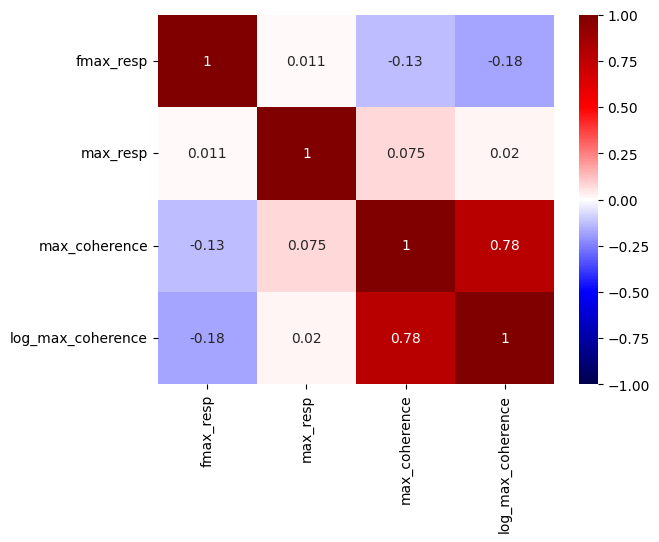

In [8]:
sns.heatmap(coherence.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: ylabel='Frequency'>

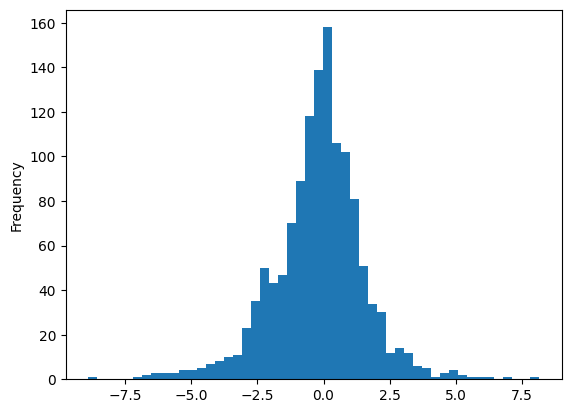

In [9]:
coherence_baselined['log_max_coherence'].plot.hist(bins = 50)

In [10]:
pos = get_pos()

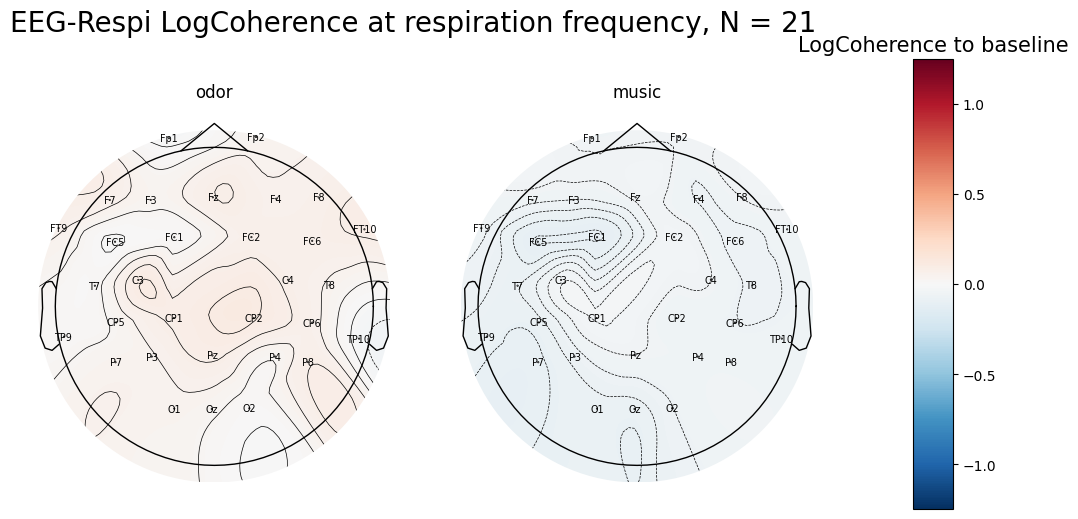

In [11]:
q_diff = 0.

df = coherence_baselined

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)['log_max_coherence'].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)['log_max_coherence'].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogCoherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'log_coherence_substract_baseline.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

/tmp/ipykernel_35067/1421536056.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))


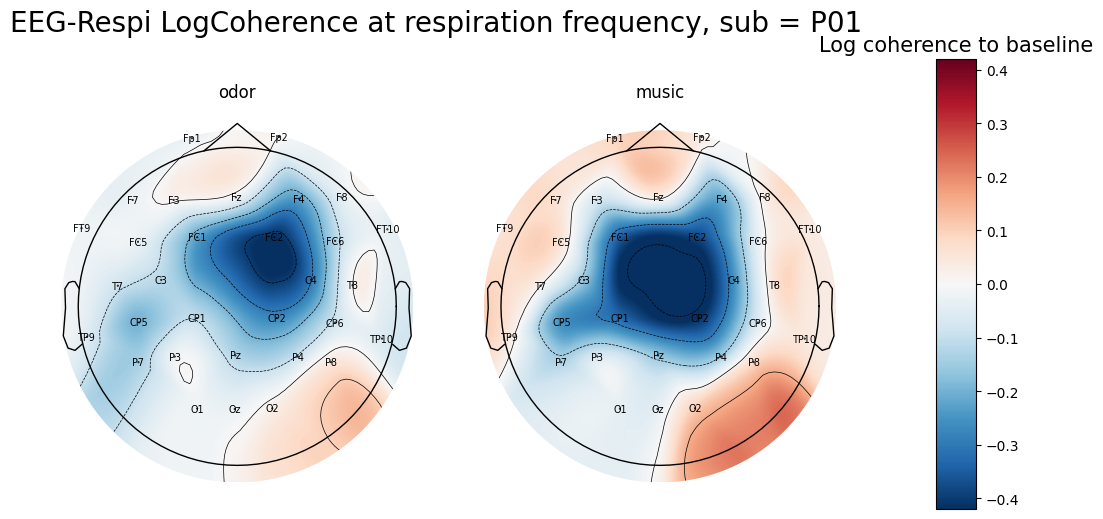

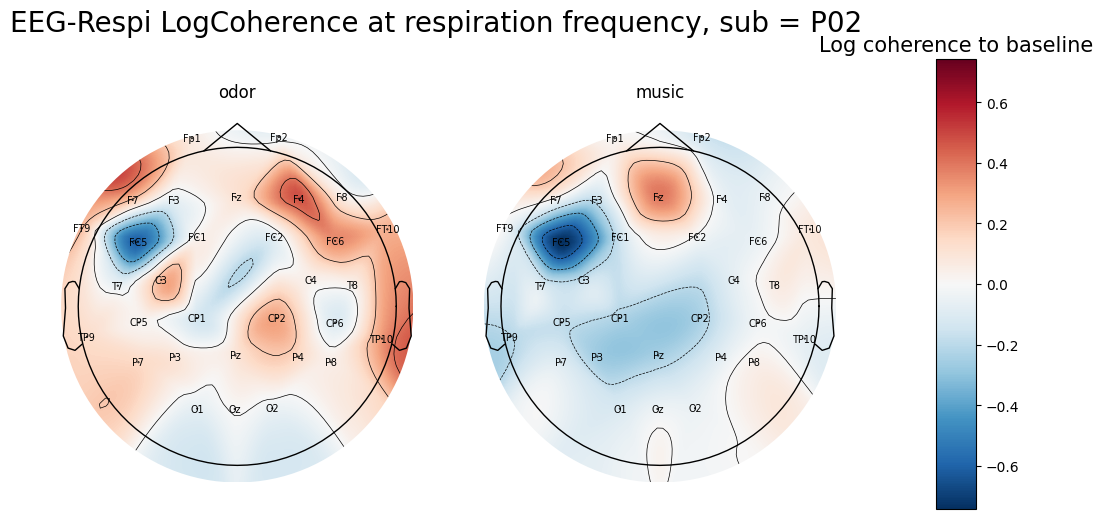

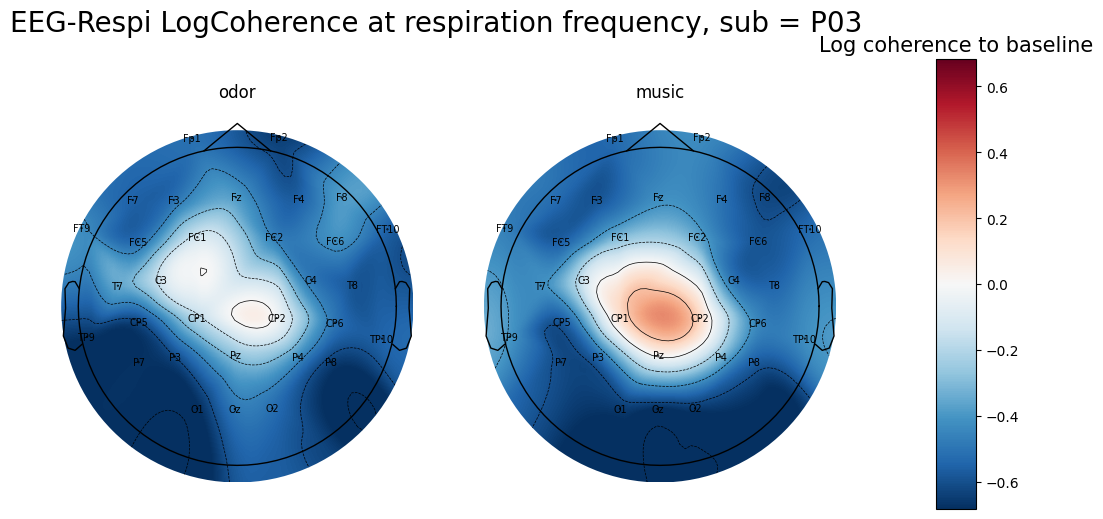

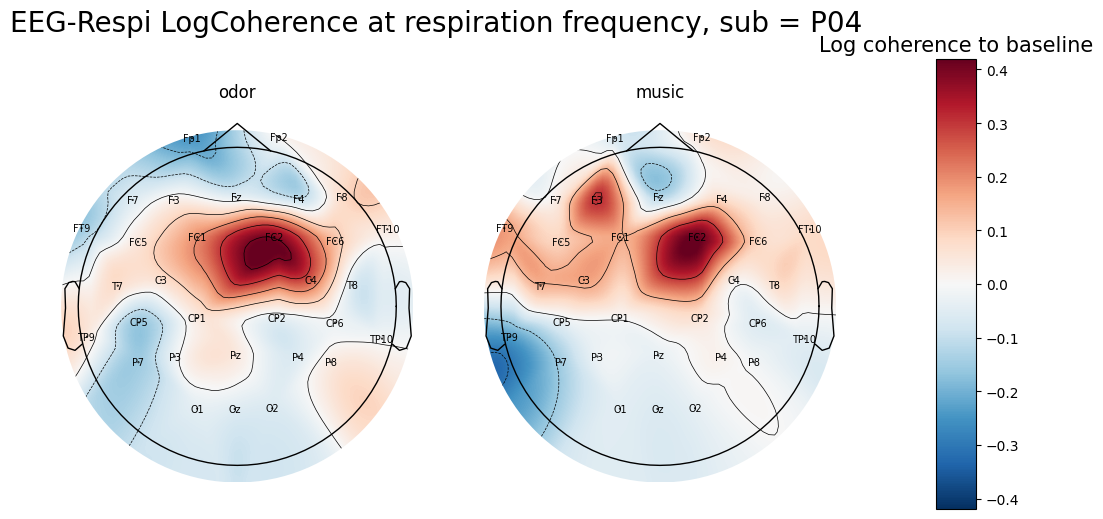

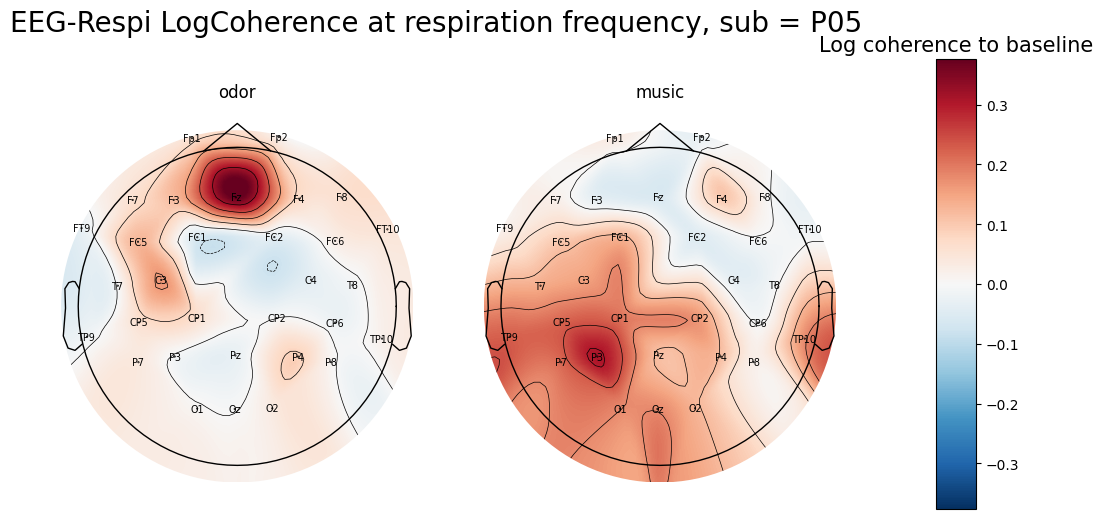

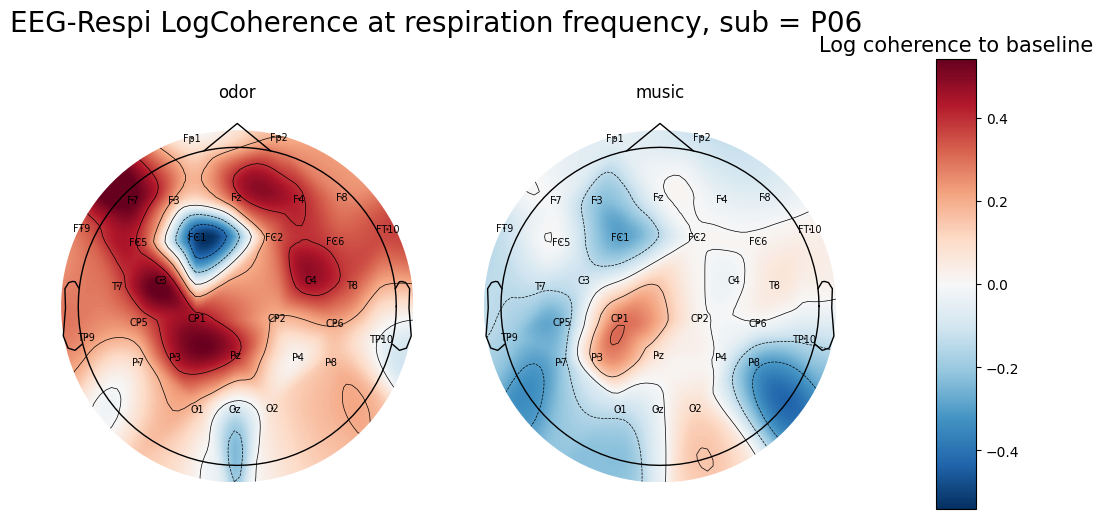

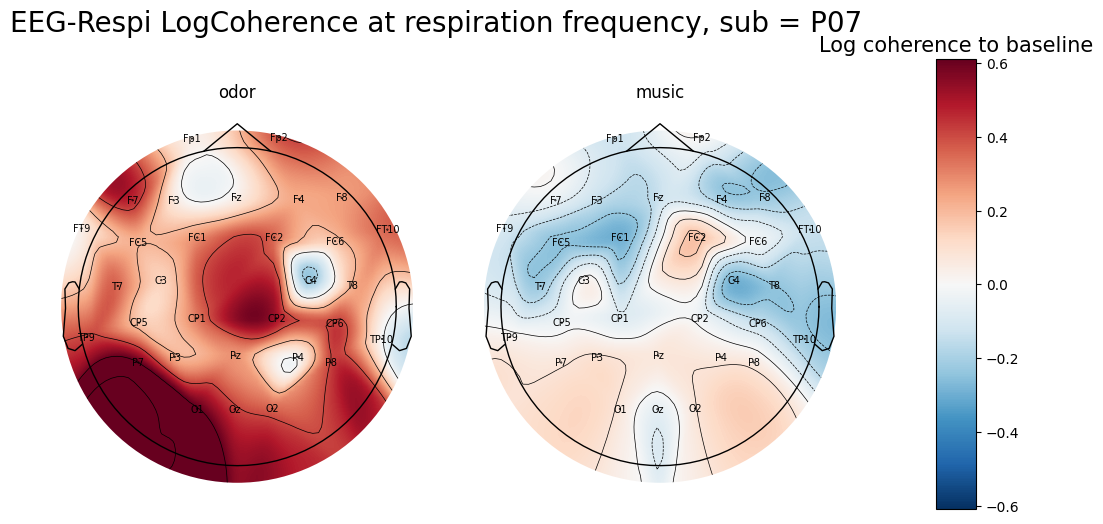

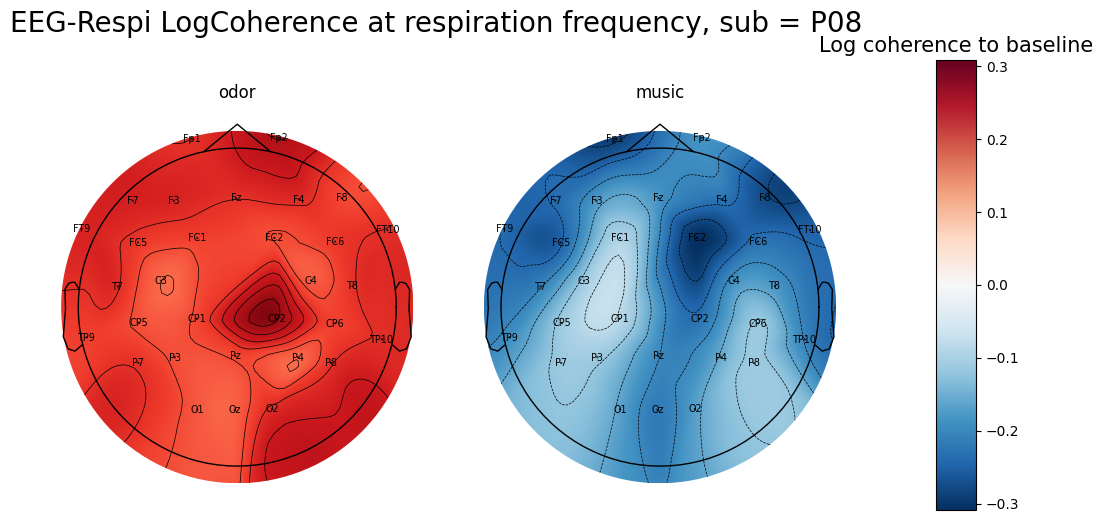

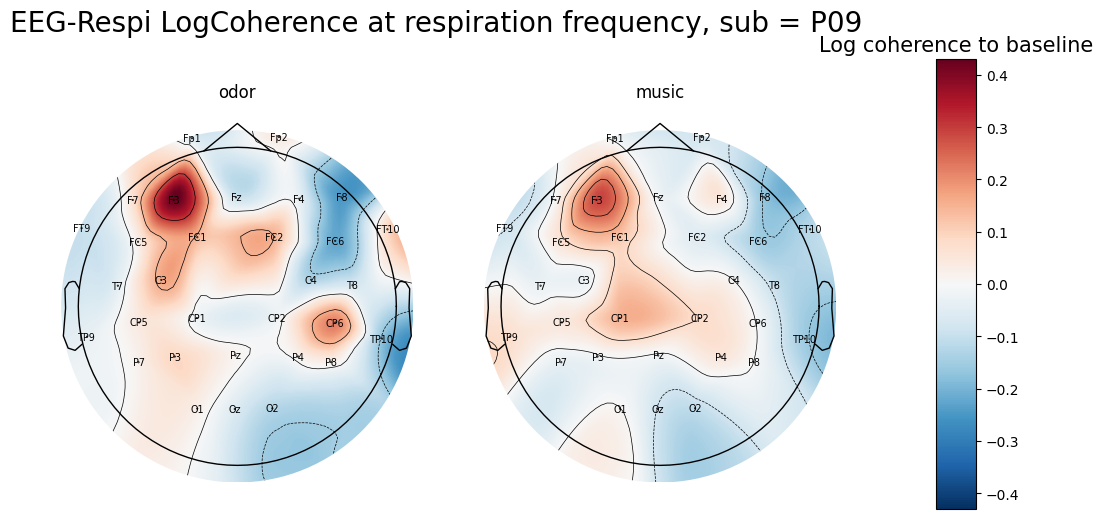

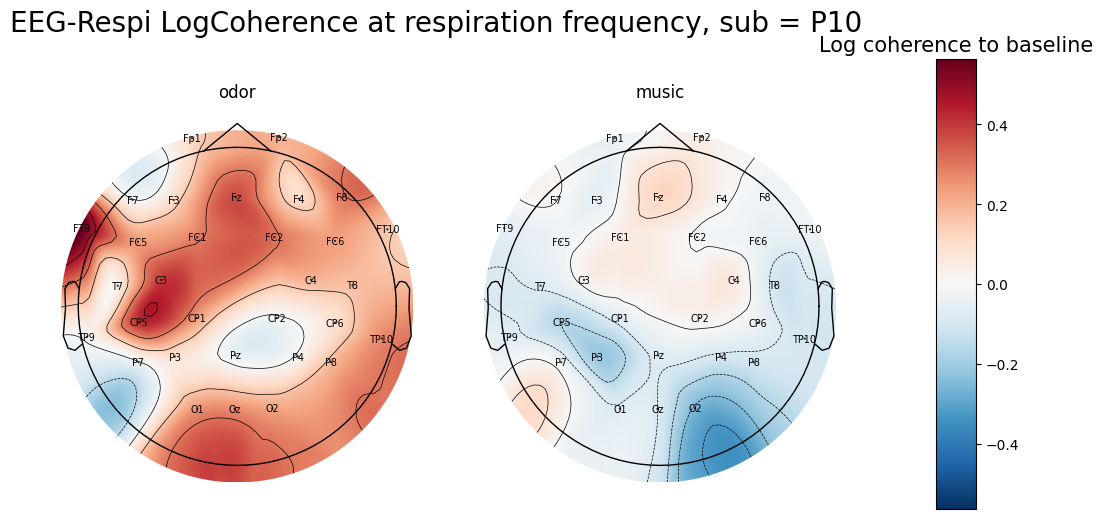

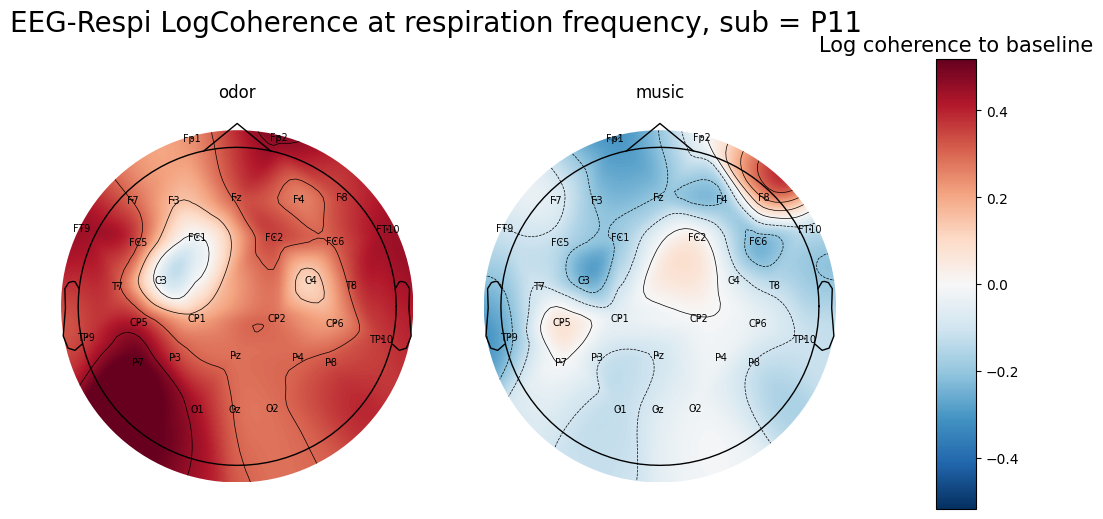

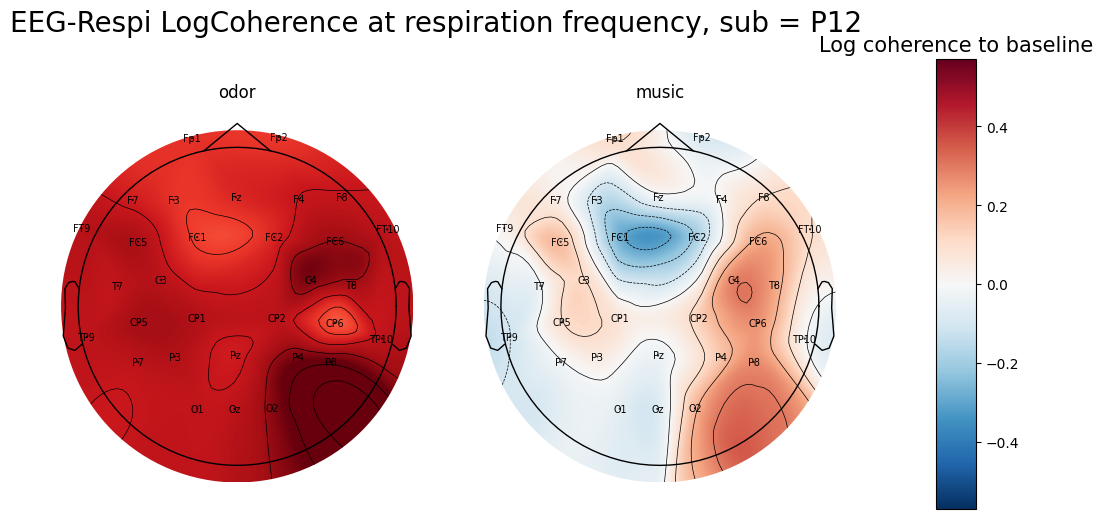

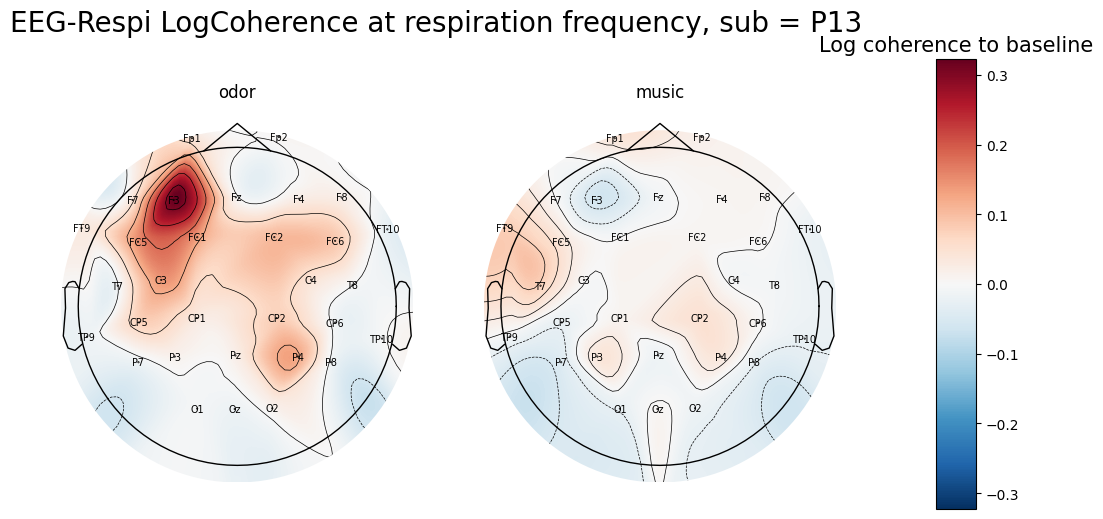

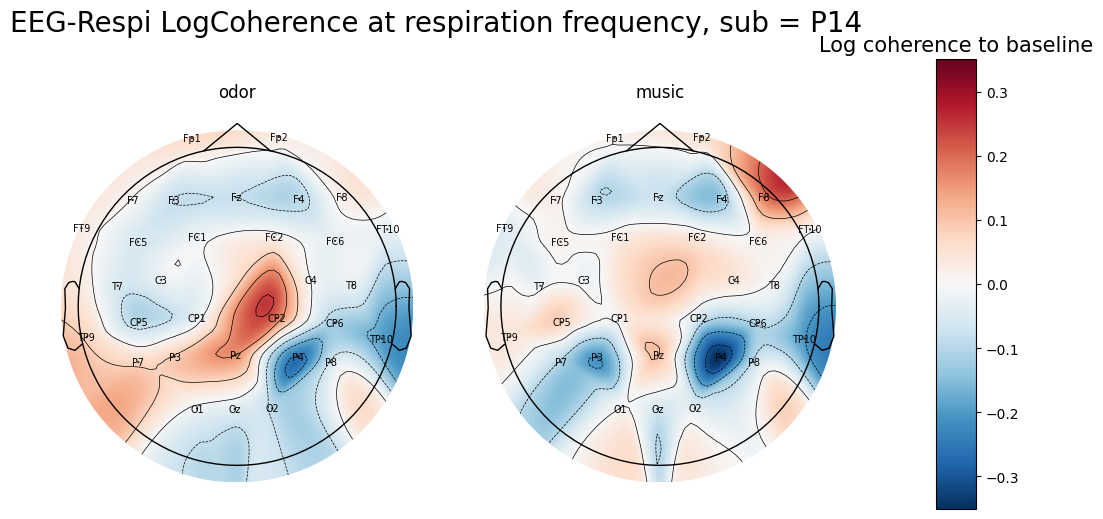

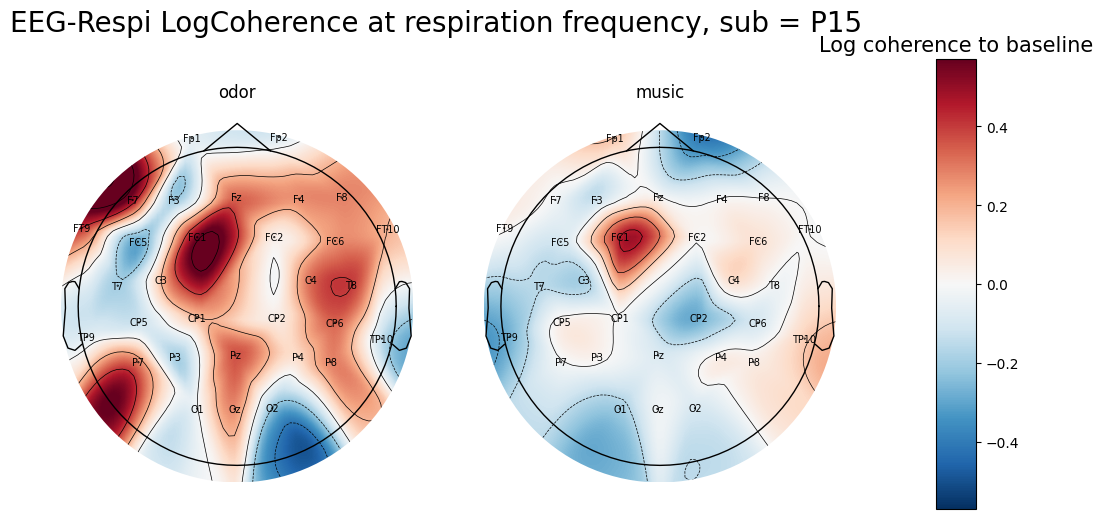

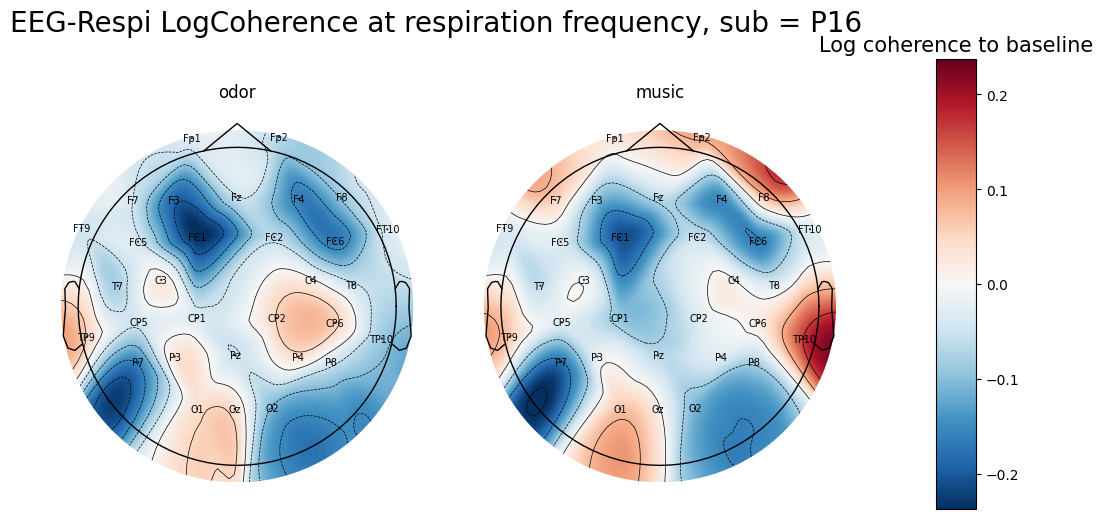

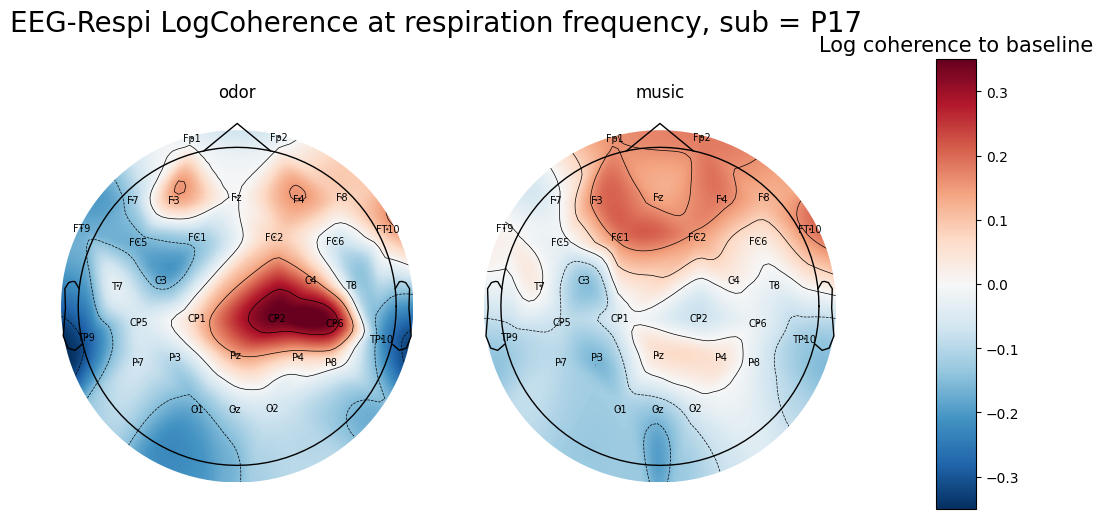

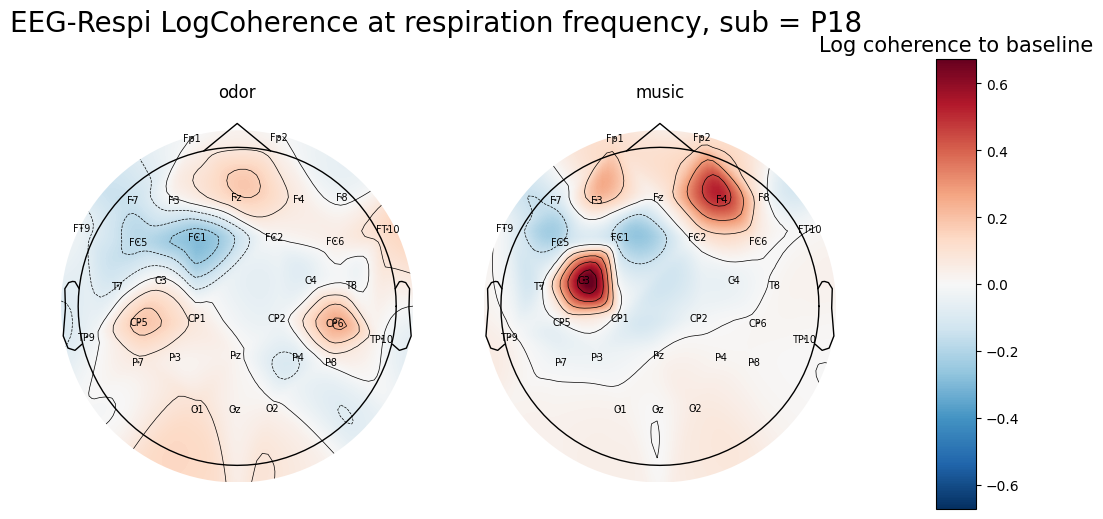

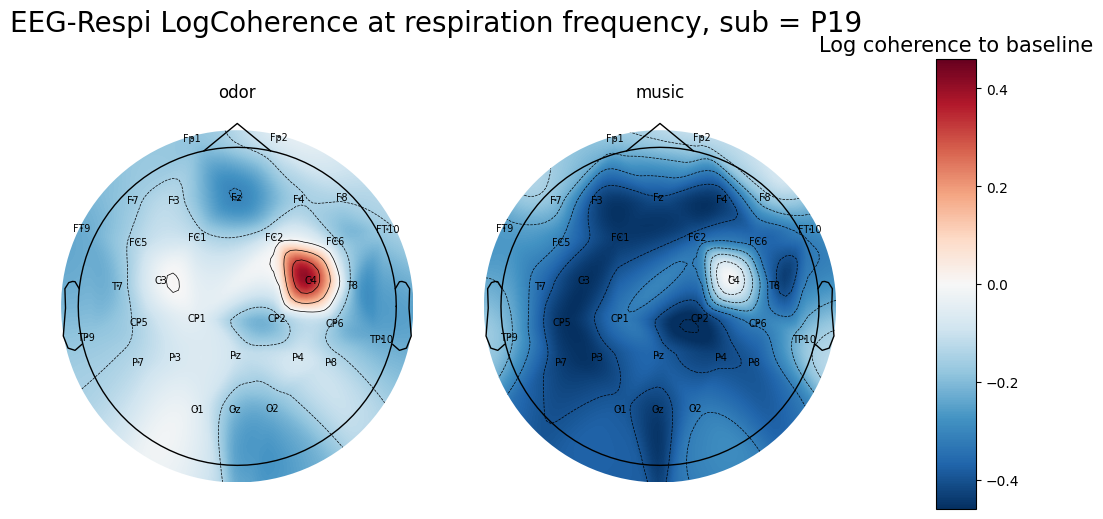

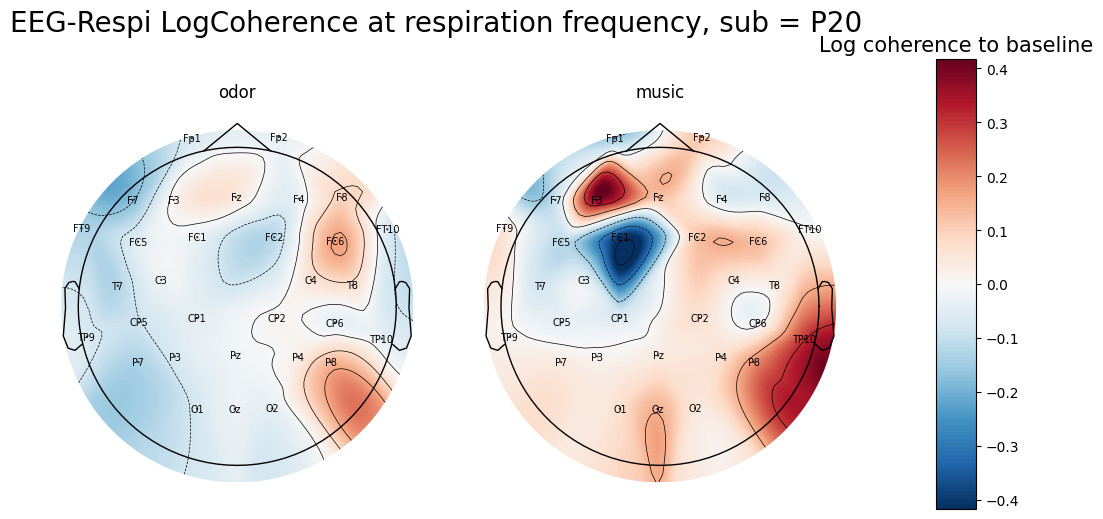

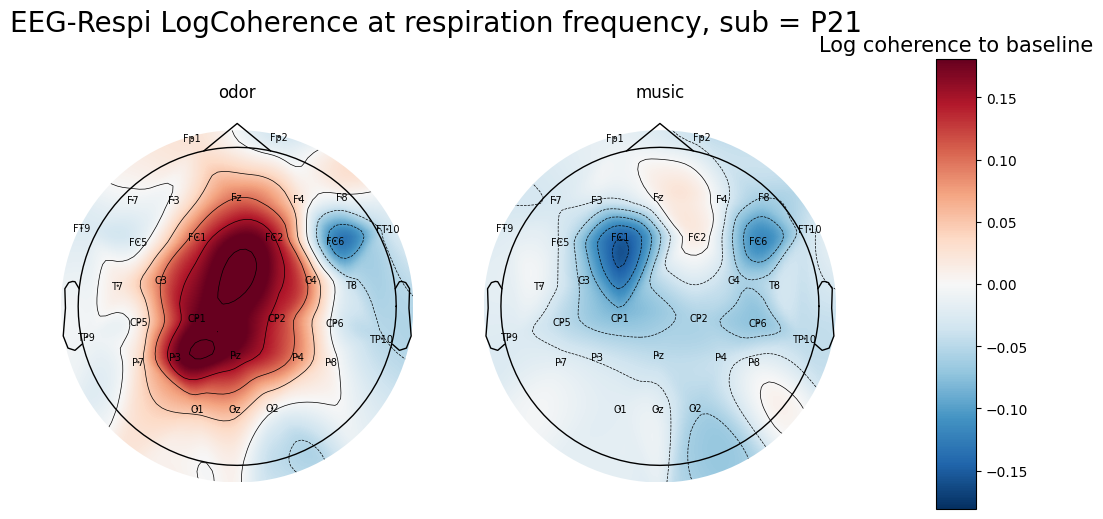

In [12]:
q_diff = 0.

for subject in subject_keys:
    df = coherence_baselined[coherence_baselined['participant'] == subject]

    vmin = df.groupby(['session','chan']).mean(numeric_only = True)['max_coherence'].quantile(q_diff)
    vmax = df.groupby(['session','chan']).mean(numeric_only = True)['max_coherence'].quantile(1 - q_diff)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, sub = {subject}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Log coherence to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'coherence_at_resp' / 'by_subject' / f'{subject}.png'
    

    fig.savefig(file, bbox_inches = 'tight')

    fig.show()